<a href="https://colab.research.google.com/github/lightknight64bit/segmentation-using-cityscapes/blob/main/cityscapes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download the dataset  
Cityscapes is a very popular dataset known for image segmentation. The dataset can be downloaded through the dataset's official site [Cityscape](https://www.cityscapes-dataset.com/) . All it takes is creating a free account. The script below downloads the dataset automatically given the username and password.

In [ ]:
!wget --keep-session-cookies --save-cookies=cookies.txt --post-data 'username=lightknight&password=j@G1ugullu&submit=Login' https://www.cityscapes-dataset.com/login/
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=1
!wget --load-cookies cookies.txt --content-disposition https://www.cityscapes-dataset.com/file-handling/?packageID=3
!unzip gtFine_trainvaltest.zip
!unzip leftImg8bit_trainvaltest.zip
!rm gtFine_trainvaltest.zip
!rm leftImg8bit_trainvaltest.zip
!rm index.html

Streaming output truncated to the last 5000 lines.
 extracting: leftImg8bit/train/jena/jena_000074_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000040_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000020_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000030_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000005_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000059_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000100_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000034_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000089_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000104_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000107_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000080_000019_leftImg8bit.png  
 extracting: leftImg8bit/train/jena/jena_000006_000019_leftImg8bit.png  


# Import necessary libraries
We will be using pytorch for creating the model and for progressive resizing, PIL for opening images and numpy for processing. 

In [ ]:
import torch #torch 
import torchvision #torchvision
import torchvision.transforms as T #torchvision transforms
import torchvision.transforms.functional as TF #torchvision functional transforms
from torch.utils import data #data utils
import torch.nn as nn #neural network module
import os #os module
from PIL import Image #Image
import numpy as np# numpy

# Defining the dataset
We define a class that takes some image transformations and type of split(train, valid, test) as input and gives the processed image as output. 

For semantic segmentation we will only be predicting 4 classes(road, sky,car and everything else) in the image and hence we also need to preprocess our target images as such.

In [ ]:
class cityscapes(data.Dataset):
  def __init__(self, split='train', transforms=T.ToTensor(),im_size=(224,224)):
    self.split = split #define the split mode
    self.im_size= im_size #define the output image size
    self.transforms = transforms #define the input image transforms
    
    self.mapping = {
            0: 0,  # unlabeled
            1: 0,  # ego vehicle
            2: 0,  # rect border
            3: 0,  # out of roi
            4: 0,  # static
            5: 0,  # dynamic
            6: 0,  # ground
            7: 1,  # road
            8: 0,  # sidewalk
            9: 0,  # parking
            10: 0,  # rail track
            11: 0,  # building
            12: 0,  # wall
            13: 0,  # fence
            14: 0,  # guard rail
            15: 0,  # bridge
            16: 0,  # tunnel
            17: 0,  # pole
            18: 0,  # polegroup
            19: 0,  # traffic light
            20: 0,  # traffic sign
            21: 0,  # vegetation
            22: 0,  # terrain
            23: 2,  # sky
            24: 0,  # person
            25: 0,  # rider
            26: 3,  # car
            27: 0,  # truck
            28: 0,  # bus
            29: 0,  # caravan
            30: 0,  # trailer
            31: 0,  # train
            32: 0,  # motorcycle
            33: 0,  # bicycle
            -1: 0  # licenseplate
        }#mapping obtained from official pytorch code for cityscapes dataset and has been modified(road is 1, sky is 2, car is 3 and 0 for everything else)
    self.images = [] 
    self.masks = []
    for city in os.listdir(f'./leftImg8bit/{self.split}/'):
      mask_files = os.path.join(f'./gtFine/{self.split}/', city)
      im_files = os.path.join(f'./leftImg8bit/{self.split}/', city)
      for im in os.listdir(im_files):
        self.images.append(os.path.join(im_files, im))#append images
        masks = im.replace('leftImg8bit','gtFine_labelIds')
        self.masks.append(os.path.join(mask_files,masks))#append target


  def __getitem__(self, idx):
    image = self.transforms(Image.open(self.images[idx]).convert("RGB")) #open image and apply image transformations
    target = np.array(Image.open(self.masks[idx]).convert("L")) #open target image
    target = torch.from_numpy(target).to('cuda') #convert to torch
    target = self.mask_to_class(target).to('cuda')#convert mapping to our own mapping(function given at the ending of the class)
    return TF.resize(image,self.im_size, interpolation=Image.NEAREST) ,TF.resize(target.unsqueeze(0), self.im_size, interpolation = Image.NEAREST) #resize and give output
    

  

  def __len__(self):
    return len(self.images) # return total number of images

  def mask_to_class(self, mask):
    new_mask = torch.zeros_like(mask)#define an empty array
    for k in self.mapping:
      new_mask[mask==k] = self.mapping[k]#redefine mappings

    return new_mask#return newly mapped mask

  

We define transformations here as our model(resnet34 backend expects imagenet standard normalized images)

In [ ]:
a = T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])])#convert to torch tensor and normalize according to image net standards
                                     
train_set = cityscapes( split = 'train',transforms=a )#define the train dataset

In [ ]:
train_loader = data.DataLoader(train_set, batch_size=4) #define trainloader

## Show images

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


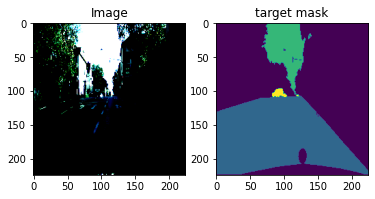

In [ ]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 2)
ax[0].imshow(train_set[0][0].permute(1,2,0).cpu().numpy())
ax[0].set_title("Image")
ax[1].imshow(train_set[0][1].squeeze(0).cpu().numpy())
ax[1].set_title("target mask")
plt.show()

# Define model
For semantic segmentation we use semantic models. For this particular case I have used a Unet model with resnet34 encoder as resnet34 itself won't suffice for segmentation.The resnet34 encoder is pretrained on Image net.  

Here's how a resnet34 encoder Unet looks like.  

![Unet model with resnet34 encoder!](https://forums.fast.ai/uploads/default/original/3X/1/3/135d5facd772ae16cee7360d0a0bbea8c74d5398.jpeg)

In [ ]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )#Unet uses conv2d followed by relu almost everywhere so I just defined a convrelu model instead of typing conv2d and relu unnecesarily

class ResnetUnet(nn.Module):
  def __init__(self):
        super(ResnetUnet, self).__init__()
        self.encoder = torchvision.models.resnet34(pretrained=True)#pretrained resnet34
        self.encoder_base_layers = list(self.encoder.children())#check the output layers
        self.layer0 = nn.Sequential(*self.encoder_base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)#add a convrelu layer after between resnet34 output layers(after 3 layers)
        self.layer1 = nn.Sequential(*self.encoder_base_layers[3:5]) 
        self.layer1_1x1 = convrelu(64, 64, 1, 0)#add a convrelu layer after between resnet34 output layers(after 5 layers)
        self.layer2 = self.encoder_base_layers[5]  
        self.layer2_1x1 = convrelu(128, 128, 1, 0)#add a convrelu layer after the 5th layer
        self.layer3 = self.encoder_base_layers[6]  
        self.layer3_1x1 = convrelu(256, 256, 1, 0)#add a convrelu layer after the 6th layer
        self.layer4 = self.encoder_base_layers[7]  
        self.layer4_1x1 = convrelu(512, 512, 1, 0)#add a convrelu layer after the 7th layer

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)#upsample the image for decoding

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)#use convrelu to decrease size
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)#use convrelu to decrease size
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)#use convrelu to decrease size
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)#use convrelu to decrease size

        self.conv_original_size0 = convrelu(3, 64, 3, 1)#use convrelu to decrease size
        self.conv_original_size1 = convrelu(64, 64, 3, 1)#use convrelu to decrease size
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)#use convrelu to decrease size

        self.conv_last = nn.Conv2d(64, 4, 1)#use conv2d to decrease size(We don't add any activation here as the loss function automatically applies softmax for us)
  def forward(self, input):
    
    

        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out #return output image

# Train the model 
We train the model using Stochastic gradient descent with a learning rate of 0.01 and crossentropy loss as the loss function

In [ ]:
import torch.optim as optim
m = ResnetUnet().cuda()
optimM = torch.optim.SGD(m.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Here's how the model shape varies for input shape 224x224 RGB image

In [ ]:
!pip install torchsummary
from torchsummary import summary
summary(m, (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
            Conv2d-6         [-1, 64, 112, 112]           9,408
       BatchNorm2d-7         [-1, 64, 112, 112]             128
       BatchNorm2d-8         [-1, 64, 112, 112]             128
              ReLU-9         [-1, 64, 112, 112]               0
             ReLU-10         [-1, 64, 112, 112]               0
        MaxPool2d-11           [-1, 64, 56, 56]               0
        MaxPool2d-12           [-1, 64, 56, 56]               0
           Conv2d-13           [-1, 64, 56, 56]          36,864
           Conv2d-14           [-1, 64,

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
epochs = 3
losses = []
for epoch in range(epochs):
  for i, (im, mask) in enumerate(train_loader):
    im = im.to('cuda')
    m.zero_grad()
    
    mask = mask.squeeze(1).long().to('cuda')
    out = m(im).to('cuda')
    l = criterion(out, mask)
    l.backward()
    optimM.step()
    
    if i%50==0:
      print(f'[{epoch+1}/{epochs}] [{i}/{len(train_loader)}] Loss:{l.item()}')
      losses.append(l.item())


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


[1/3] [0/744] Loss:1.4337751865386963
[1/3] [50/744] Loss:1.032143235206604
[1/3] [100/744] Loss:0.978748083114624
[1/3] [150/744] Loss:0.8304137587547302
[1/3] [200/744] Loss:0.70022052526474
[1/3] [250/744] Loss:0.5237882733345032
[1/3] [300/744] Loss:0.4603385031223297
[1/3] [350/744] Loss:0.3759208917617798
[1/3] [400/744] Loss:0.521308422088623
[1/3] [450/744] Loss:0.4246833920478821
[1/3] [500/744] Loss:0.4896176755428314
[1/3] [550/744] Loss:0.4267514944076538
[1/3] [600/744] Loss:0.3490161597728729
[1/3] [650/744] Loss:0.3662283718585968
[1/3] [700/744] Loss:0.2720220983028412
[2/3] [0/744] Loss:0.40488749742507935
[2/3] [50/744] Loss:0.2985558807849884
[2/3] [100/744] Loss:0.36461693048477173
[2/3] [150/744] Loss:0.2442149668931961
[2/3] [200/744] Loss:0.2488885223865509
[2/3] [250/744] Loss:0.21499985456466675
[2/3] [300/744] Loss:0.25923603773117065
[2/3] [350/744] Loss:0.1905721127986908
[2/3] [400/744] Loss:0.2607973515987396
[2/3] [450/744] Loss:0.27177366614341736
[2/3] 

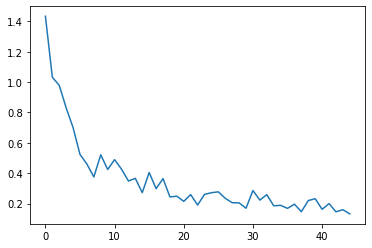

In [ ]:
plt.plot(losses) #plot the losses

Here's how the predicted masks look like for each input image. Target image is put here for comparision

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


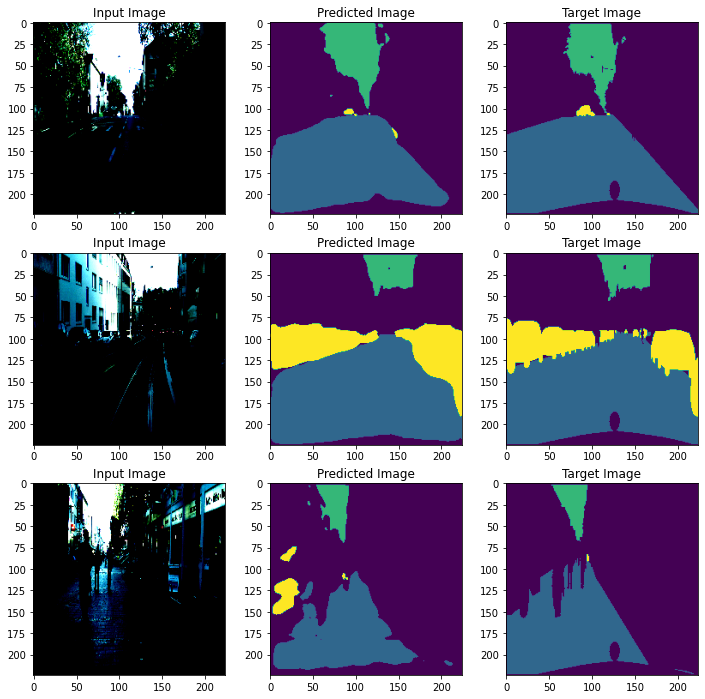

In [ ]:
m.eval()
_, ax = plt.subplots(3,3, figsize=(12,12))
for i in range(3):
  im = train_set[i][0].to('cuda')
  target = train_set[i][1].cpu()
  pred = torch.argmax(m(im.unsqueeze(0)).detach().cpu(), 1).squeeze(0)
  
  for j in range(3):
    if j == 0:
      ax[i][j].imshow(im.detach().cpu().permute(1,2,0))
      ax[i][j].set_title("Input Image")

    if j == 1:
      ax[i][j].imshow(pred)
      ax[i][j].set_title("Predicted Image")

    if j == 2:
      ax[i][j].imshow(target.squeeze(0))
      ax[i][j].set_title("Target Image")
  
    

# Progressive Resizing
We define progressive resizing as training a model with different sizes of images with image size being increased progressively, here we train the model on 3 image sizes :- 64x64, 128x128 and 224x224 for 1 epoch each in that order.

In [ ]:
train_set_64 = cityscapes( split = 'train',transforms=a ,im_size=(64,64))#load 64x64 images
train_set_128 = cityscapes( split = 'train',transforms=a ,im_size=(128,128))#Load 128x128 images
train_set_224= cityscapes( split = 'train',transforms=a ,im_size=(224,224))#load 224x224 images
train_loader_64 = data.DataLoader(train_set_64, batch_size=4)
train_loader_128 = data.DataLoader(train_set_128, batch_size=4)
train_loader_224 = data.DataLoader(train_set_224, batch_size=4)

In [ ]:
m_progressive = ResnetUnet().cuda()#progressive model
optimM_prog = torch.optim.SGD(m_progressive.parameters(), lr=0.01)
# here we define an epoch which takes the trainloader as input and returns the loss after 50 images trained
def one_cycle(loader):
  losses = []
  for i, (im, mask) in enumerate(loader):
    im = im.to('cuda')
    m_progressive.zero_grad()
    
    mask = mask.squeeze(1).long().to('cuda')
    out = m_progressive(im)
    l = criterion(out, mask)
    l.backward()
    optimM_prog.step()
    
    if i%50==0:
      print(f'[{i}/{len(train_loader)}] Loss:{l.item()}')
      losses.append(l.item())

  return losses


In [ ]:
print("Using images of size 64")
loss_64 = one_cycle(train_loader_64)
print("Increasing Image size to 128")
loss_128= one_cycle(train_loader_128)
print("Increasing Image size to 224")
loss_224 = one_cycle(train_loader_224)

Using images of size 64


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


[0/744] Loss:1.431573510169983
[50/744] Loss:0.9647003412246704
[100/744] Loss:0.9993277192115784
[150/744] Loss:0.8316072821617126
[200/744] Loss:0.738009512424469
[250/744] Loss:0.5955537557601929
[300/744] Loss:0.5291436314582825
[350/744] Loss:0.42799341678619385
[400/744] Loss:0.6042855978012085
[450/744] Loss:0.4440661370754242
[500/744] Loss:0.5707462430000305
[550/744] Loss:0.4971127510070801
[600/744] Loss:0.39557749032974243
[650/744] Loss:0.4724960923194885
[700/744] Loss:0.34910571575164795
Increasing Image size to 128
[0/744] Loss:0.6554238200187683
[50/744] Loss:0.4256114065647125
[100/744] Loss:0.5552302598953247
[150/744] Loss:0.3944057822227478
[200/744] Loss:0.3282091021537781
[250/744] Loss:0.3250475227832794
[300/744] Loss:0.37050285935401917
[350/744] Loss:0.29229438304901123
[400/744] Loss:0.38388070464134216
[450/744] Loss:0.3702546954154968
[500/744] Loss:0.3235744833946228
[550/744] Loss:0.32890456914901733
[600/744] Loss:0.29513925313949585
[650/744] Loss:0.30

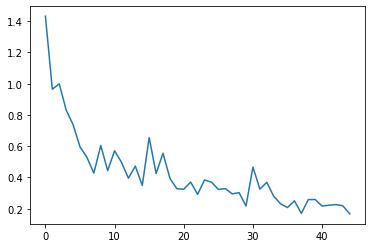

In [ ]:
total_loss = loss_64+loss_128+loss_224
plt.plot(total_loss)#plot losses

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


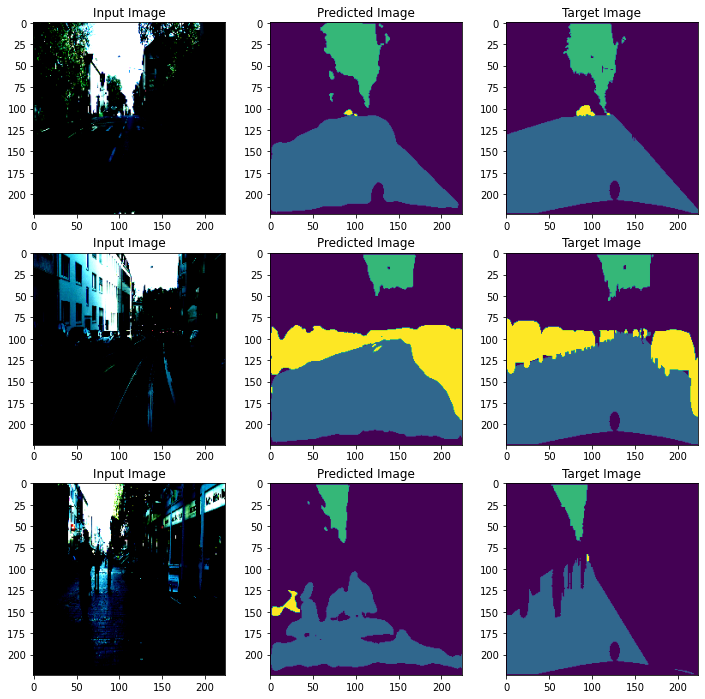

In [ ]:
m_progressive.eval()
_, ax = plt.subplots(3,3, figsize=(12,12))
for i in range(3):
  im = train_set_224[i][0].to('cuda')
  target = train_set[i][1].cpu()
  pred = torch.argmax(m_progressive(im.unsqueeze(0)).detach().cpu(), 1).squeeze(0)
  
  for j in range(3):
    if j == 0:
      ax[i][j].imshow(im.detach().cpu().permute(1,2,0))
      ax[i][j].set_title("Input Image")

    if j == 1:
      ax[i][j].imshow(pred)
      ax[i][j].set_title("Predicted Image")

    if j == 2:
      ax[i][j].imshow(target.squeeze(0))
      ax[i][j].set_title("Target Image")
  
    

The progressive resizing model provides crisper images and the loss graph shows steeper lines meaning model learns quicker(except for the occasional spikes encountered while changing sizes)

Let's compare the models on the validation dataset

In [ ]:
def multi_acc(pred, label):
    _, tags = torch.max(pred, dim = 1)
    corrects = (tags == label).float()
    acc = corrects.sum() / corrects.numel()
    acc = acc * 100
    return acc

In [ ]:
val_set = cityscapes( split = 'val',transforms=a )#define the validation dataset
val_loader = data.DataLoader(val_set, batch_size=4) #define trainloader
normal_acc = []
normal_loss = []
progressive_acc = []
progressive_loss = []
for i, (im, mask) in enumerate(val_loader):
  im = im.to('cuda')
  mask = mask.to('cuda').long().squeeze(1)
  out_normal = m(im)
  out_progressive = m_progressive(im)
  a_normal = multi_acc(out_normal, mask)
  l_normal = criterion(out_normal, mask)
  a_progressive = multi_acc(out_progressive, mask)
  l_progressive=criterion(out_progressive, mask)
  normal_acc.append(a_normal.item())
  normal_loss.append(l_normal.item())
  progressive_acc.append(a_progressive.item())
  progressive_loss.append(l_progressive.item())

normal_acc = sum(normal_acc)/len(normal_acc)
normal_loss = sum(normal_loss)/len(normal_loss)
progressive_acc = sum(progressive_acc)/len(progressive_acc)
progressive_loss = sum(progressive_loss)/len(progressive_loss)
print(f'Val accuracy for normal unet :{normal_acc}')
print(f'Val loss for normal unet :{normal_loss}')
print(f'Val accuracy for progressive unet :{progressive_acc}')
print(f'Val loss for progressive unet:{progressive_loss}')



/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:387: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Val accuracy for normal unet :90.54079083251953
Val loss for normal unet :0.24050862443447113
Val accuracy for progressive unet :89.96108325195313
Val loss for progressive unet:0.24810203701257705


We see that both the models are almost similiar with the progressive resizing model converging quicker